In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, classification_report, roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загрузка Restaurant Reviews
reviews = pd.read_csv("Restaurant_Reviews.csv", sep='\t')
print("Restaurant Reviews загружен")
print(reviews.shape)
reviews.head()

Restaurant Reviews загружен
(1000, 2)


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
# Загрузка NY Pricing
ny = pd.read_csv("NY Realstate Pricing.csv")
print("\nNY Realstate Pricing загружен")
print(ny.shape)
ny.head()


NY Realstate Pricing загружен
(17614, 12)


,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [5]:
print("Restaurant Reviews — распределение классов:")
print(reviews['Liked'].value_counts())

print("\nNY Pricing — статистика цены:")
ny['price'].describe()

Restaurant Reviews — распределение классов:
Liked
1    500
0    500
Name: count, dtype: int64

NY Pricing — статистика цены:


count    17614.000000
mean       145.455490
std        194.990677
min          0.000000
25%         70.000000
50%        109.000000
75%        170.000000
max       9999.000000
Name: price, dtype: float64

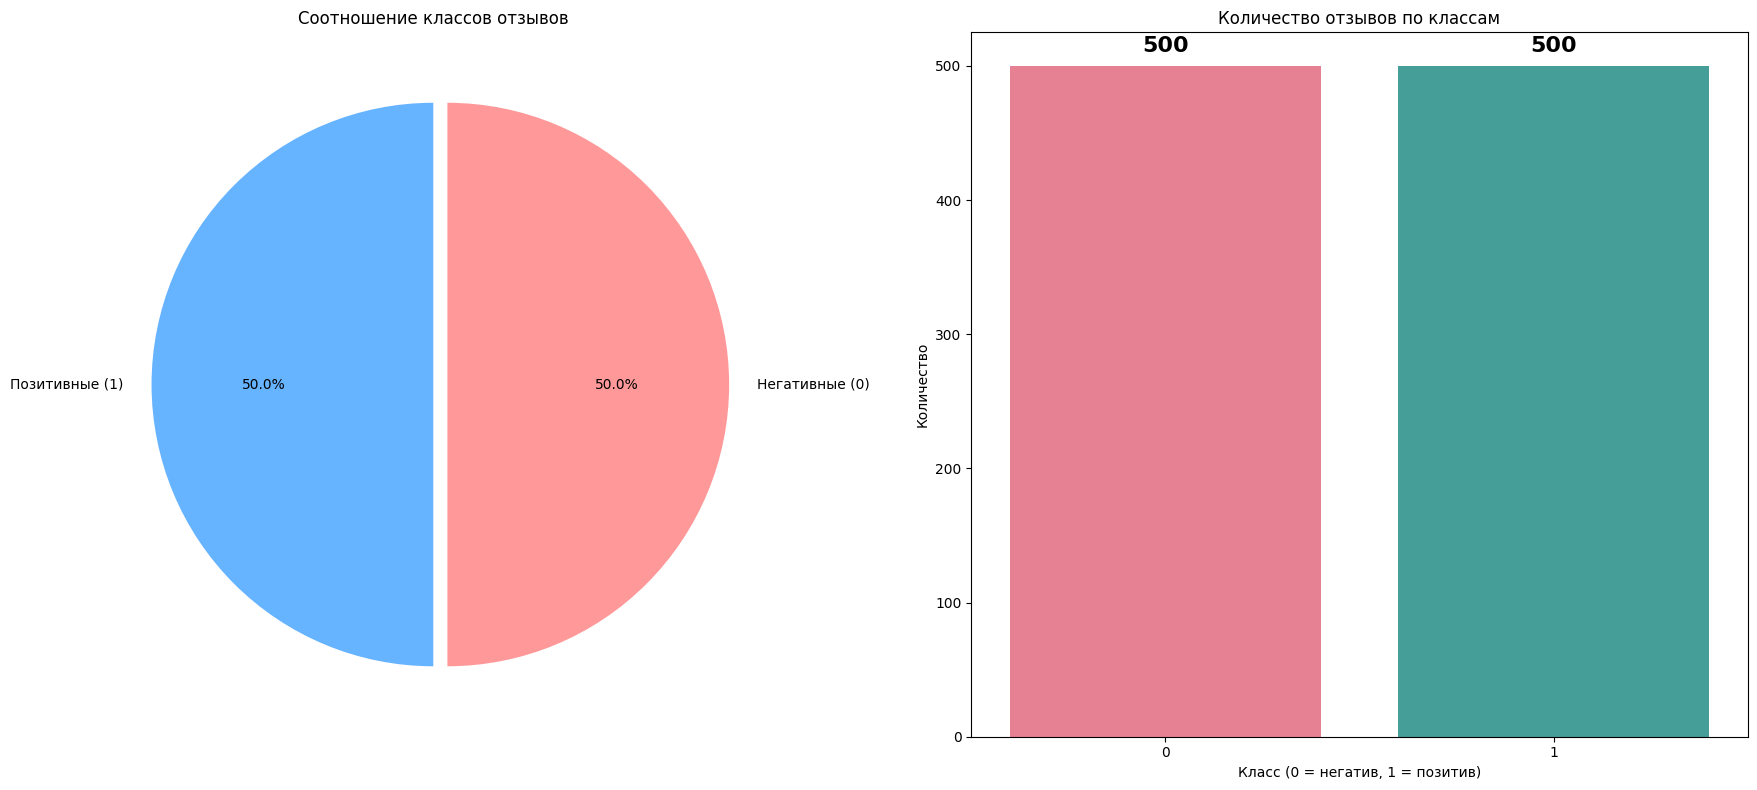

Позитивных отзывов: 500 (50.0%)
Негативных отзывов: 500 (50.0%)


In [6]:
# Круговая + столбчатая диаграмма распределения классов в Restaurant Reviews
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

likes_count = reviews['Liked'].value_counts()
axes[0].pie(likes_count.values, labels=['Позитивные (1)', 'Негативные (0)'], 
            autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'], explode=(0, 0.05))
axes[0].set_title('Соотношение классов отзывов')

sns.countplot(data=reviews, x='Liked', ax=axes[1], palette='husl')
axes[1].set_title('Количество отзывов по классам')
axes[1].set_xlabel('Класс (0 = негатив, 1 = позитив)')
axes[1].set_ylabel('Количество')
for i, v in enumerate(likes_count.values):
    axes[1].text(i, v + 10, str(v), ha='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Позитивных отзывов: {likes_count[1]} ({likes_count[1]/len(reviews)*100:.1f}%)")
print(f"Негативных отзывов: {likes_count[0]} ({likes_count[0]/len(reviews)*100:.1f}%)")

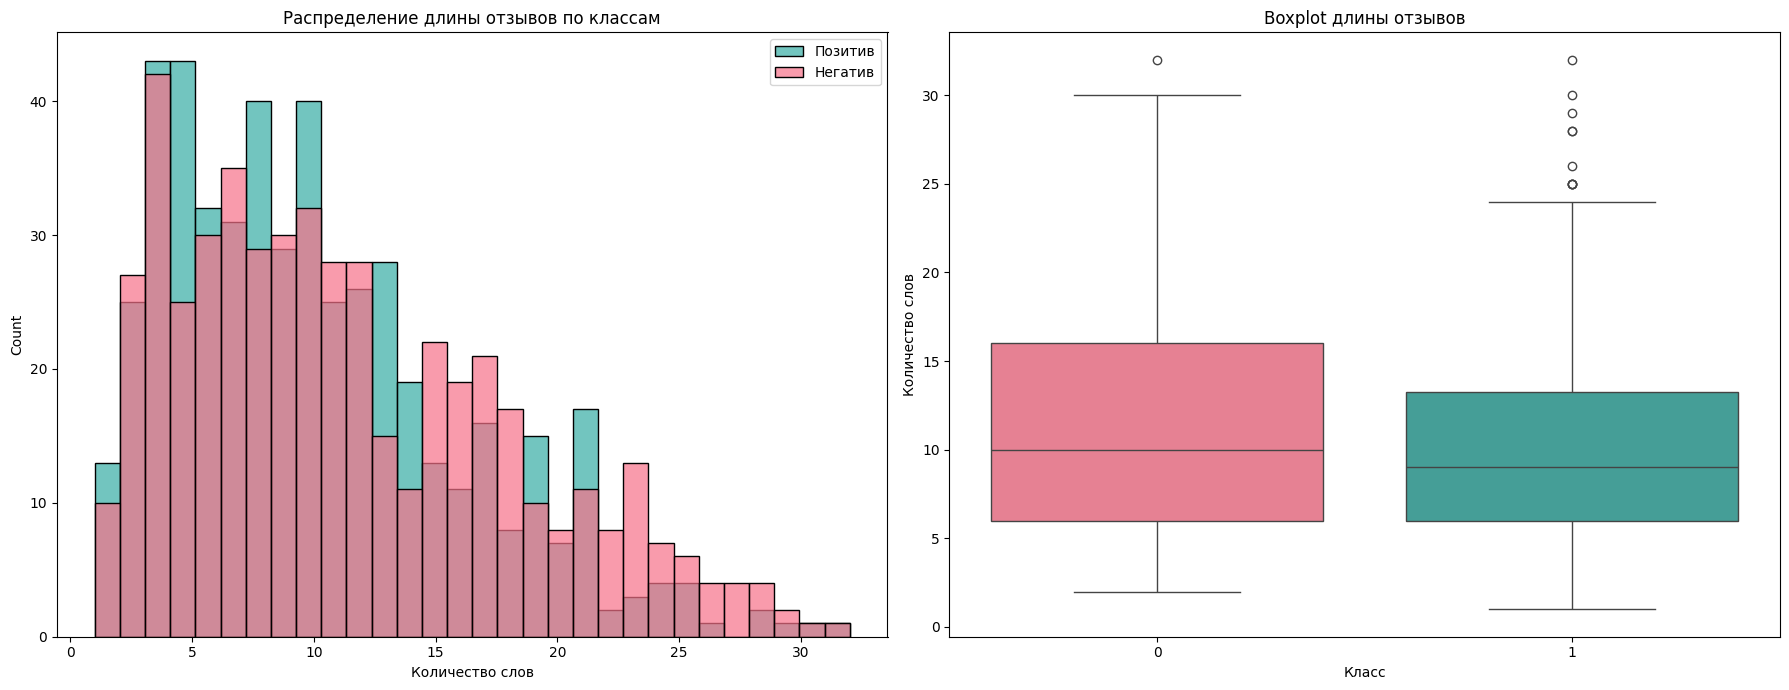

Средняя длина отзыва:
Liked
0    11.498
1    10.290
Name: length, dtype: float64


In [7]:
# Добавляем длину текста
reviews['length'] = reviews['Review'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Гистограмма длин
sns.histplot(data=reviews, x='length', hue='Liked', palette='husl', bins=30, ax=axes[0], alpha=0.7)
axes[0].set_title('Распределение длины отзывов по классам')
axes[0].set_xlabel('Количество слов')
axes[0].legend(['Позитив', 'Негатив'])

# Boxplot
sns.boxplot(data=reviews, x='Liked', y='length', palette='husl', ax=axes[1])
axes[1].set_title('Boxplot длины отзывов')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Количество слов')

plt.tight_layout()
plt.show()

print("Средняя длина отзыва:")
print(reviews.groupby('Liked')['length'].mean())

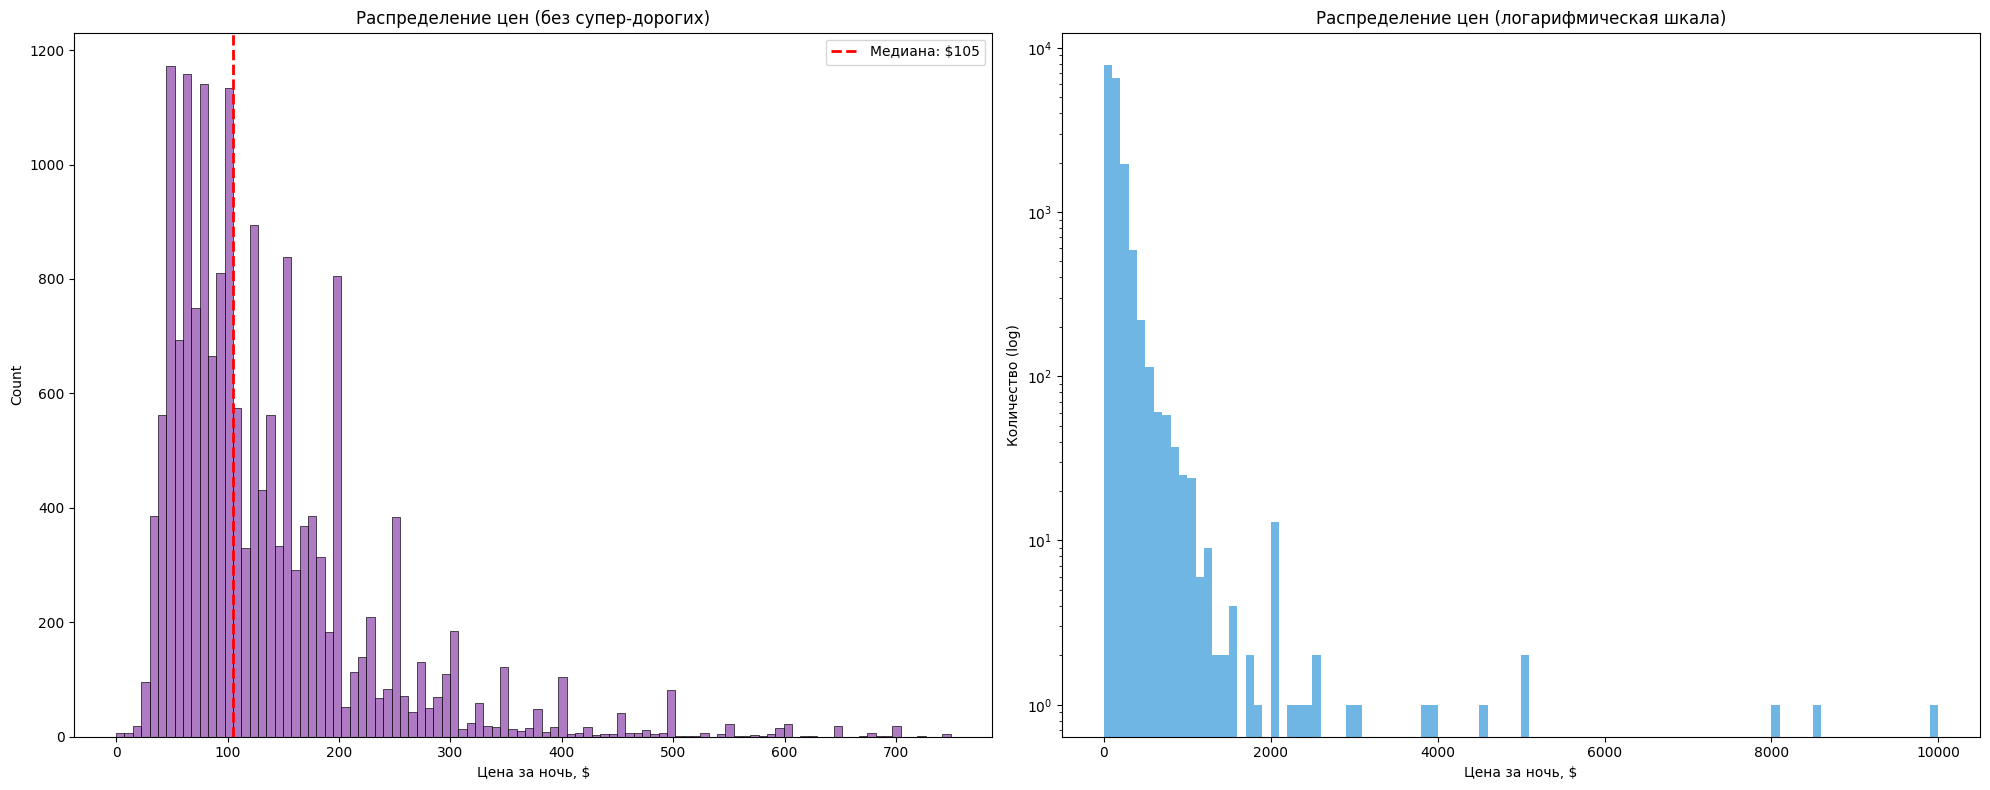

Средняя цена: $145.46
Медианная цена: $109.00
Макс цена: $9999.00
99% квантиль: $750.00


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Обычная гистограмма (с обрезкой выбросов)
ny_filtered = ny[ny['price'] < ny['price'].quantile(0.99)]  # убираем топ-1%
sns.histplot(ny_filtered['price'], bins=100, ax=axes[0], color='#9b59b6', alpha=0.8)
axes[0].set_title('Распределение цен (без супер-дорогих)')
axes[0].set_xlabel('Цена за ночь, $')
axes[0].axvline(ny_filtered['price'].median(), color='red', linestyle='--', linewidth=2, label=f"Медиана: ${ny_filtered['price'].median():.0f}")
axes[0].legend()

# Логарифмическая шкала
axes[1].hist(ny['price'], bins=100, color='#3498db', alpha=0.7, log=True)
axes[1].set_title('Распределение цен (логарифмическая шкала)')
axes[1].set_xlabel('Цена за ночь, $')
axes[1].set_ylabel('Количество (log)')

plt.tight_layout()
plt.show()

print(f"Средняя цена: ${ny['price'].mean():.2f}")
print(f"Медианная цена: ${ny['price'].median():.2f}")
print(f"Макс цена: ${ny['price'].max():.2f}")
print(f"99% квантиль: ${ny['price'].quantile(0.99):.2f}")

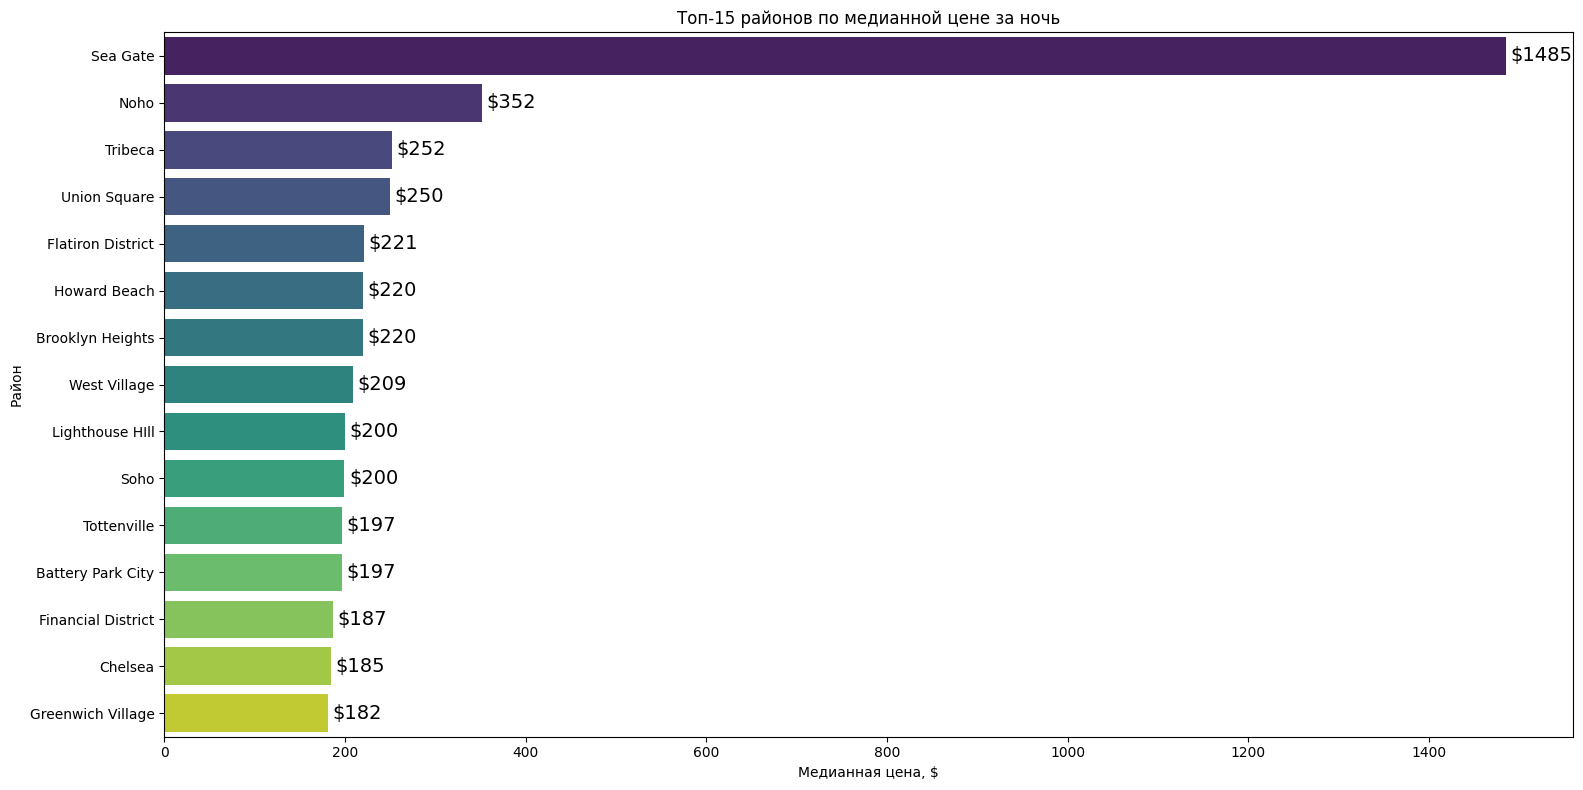

In [9]:
# Топ-15 районов по медианной цене
top_neigh = ny.groupby('neighbourhood')['price'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(16, 8))
sns.barplot(x=top_neigh.values, y=top_neigh.index, palette='viridis')
plt.title('Топ-15 районов по медианной цене за ночь')
plt.xlabel('Медианная цена, $')
plt.ylabel('Район')
for i, v in enumerate(top_neigh.values):
    plt.text(v + 5, i, f"${v:.0f}", va='center', fontsize=14)

plt.tight_layout()
plt.show()

## Предобработка текста отзывов

In [10]:
# Предобработка текста
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Добавлние самых частых и бесполезных слов
extra_stops = {"the", "and", "was", "were", "is", "are", "been", "it'", "it's", "place", "food", "nt"}
stop_words.update(extra_stops)

def clean_and_lemmatize_fast(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)         
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words 
             if w not in stop_words and len(w) > 2]
    return " ".join(words)

reviews['Review_clean'] = reviews['Review'].apply(clean_and_lemmatize_fast)

reviews[['Review', 'Review_clean', 'Liked']].head(10)

,Review,Review_clean,Liked
0,Wow... Loved this place.,wow loved,1
1,Crust is not good.,crust good,0
2,Not tasty and the texture was just nasty.,tasty texture nasty,0
3,Stopped by during the late May bank holiday of...,stopped late may bank holiday rick steve recom...,1
4,The selection on the menu was great and so wer...,selection menu great price,1
5,Now I am getting angry and I want my damn pho.,getting angry want damn pho,0
6,Honeslty it didn't taste THAT fresh.),honeslty didnt taste fresh,0
7,The potatoes were like rubber and you could te...,potato like rubber could tell made ahead time ...,0
8,The fries were great too.,fry great,1
9,A great touch.,great touch,1


In [11]:
    # Векторизация текста с TF-IDF

    from sklearn.feature_extraction.text import TfidfVectorizer

    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
        stop_words='english'
    )

    X_text = vectorizer.fit_transform(reviews['Review_clean'])
    y_text = reviews['Liked']

    print(f"Размер матрицы: {X_text.shape}")
    print(f"Пример слов: {list(vectorizer.vocabulary_.keys())[:20]}")

Размер матрицы: (1000, 445)
Пример слов: ['wow', 'loved', 'good', 'tasty', 'texture', 'nasty', 'recommendation', 'selection', 'menu', 'great', 'price', 'getting', 'want', 'damn', 'pho', 'didnt', 'taste', 'fresh', 'potato', 'like']


In [12]:
# Разделение на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Создаём список для сбора результатов 
results = []

Train size: 800, Test size: 200


In [13]:
# бейзлайн с RandomForestClassifier

rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,        
    oob_score=True       
)

rf_base.fit(X_train, y_train)
pred_base = rf_base.predict(X_test)

acc_base = accuracy_score(y_test, pred_base)
f1_base = f1_score(y_test, pred_base)
oob_score = rf_base.oob_score_

print(f"Accuracy:          {acc_base:.4f}")
print(f"F1-score:          {f1_base:.4f}")
print(f"OOB-оценка:        {oob_score:.4f}")
print(f"Количество деревьев: {rf_base.n_estimators}")

results.append({
    'Задача': 'Классификация',
    'Этап': 'Бейзлайн',
    'Модель': 'RandomForest',
    'Accuracy': acc_base,
    'F1': f1_base
})


Accuracy:          0.7700
F1-score:          0.7629
OOB-оценка:        0.7550
Количество деревьев: 100


In [15]:
features_reg = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'availability_2020', 'days_occupied_in_2019']
X_reg = ny[features_reg].fillna(0)
y_reg = ny['price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

MAE:           68.29
RMSE:          168.59
OOB R²:        0.1267 ← это как кросс-валидация бесплатно!
Количество деревьев: 200


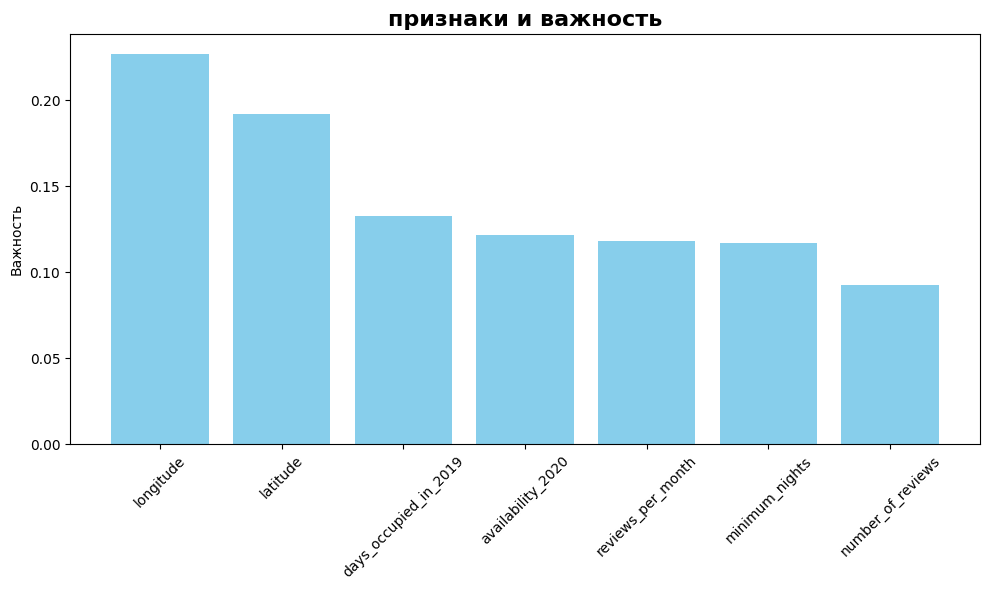

longitude            → 0.2269
latitude             → 0.1916
days_occupied_in_2019 → 0.1325
availability_2020    → 0.1218
reviews_per_month    → 0.1178
minimum_nights       → 0.1169
number_of_reviews    → 0.0925


In [17]:
# Бейзлайн с RandomForestRegressor

rf_reg_base = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    oob_score=True,           
    max_features='sqrt'       
)

rf_reg_base.fit(X_train_r, y_train_r)
pred_reg = rf_reg_base.predict(X_test_r)

mae_base = mean_absolute_error(y_test_r, pred_reg)
rmse_base = np.sqrt(mean_squared_error(y_test_r, pred_reg))
oob_r2 = rf_reg_base.oob_score_  

print(f"MAE:           {mae_base:.2f}")
print(f"RMSE:          {rmse_base:.2f}")
print(f"OOB R²:        {oob_r2:.4f} ← это как кросс-валидация бесплатно!")
print(f"Количество деревьев: {rf_reg_base.n_estimators}")

# Добавляем в таблицу
results.append({
    'Задача': 'Регрессия',
    'Этап': 'Бейзлайн',
    'Модель': 'RandomForest',
    'MAE': mae_base,
    'RMSE': rmse_base
})

importances = rf_reg_base.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("признаки и важность", fontsize=16, fontweight='bold')
plt.bar(range(len(importances)), importances[indices], color='skyblue')
plt.xticks(range(len(importances)), [features_reg[i] for i in indices], rotation=45)
plt.ylabel("Важность")
plt.tight_layout()
plt.show()

for i in indices:
    print(f"{features_reg[i]:<20} → {importances[i]:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшие параметры: {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'oob_score': True}
Лучшая accuracy на CV: 0.7863

ТЕСТОВЫЕ МЕТРИКИ:
Accuracy:    0.7700
F1-score:    0.7700
ROC-AUC:     0.8840
OOB-оценка:  0.7525


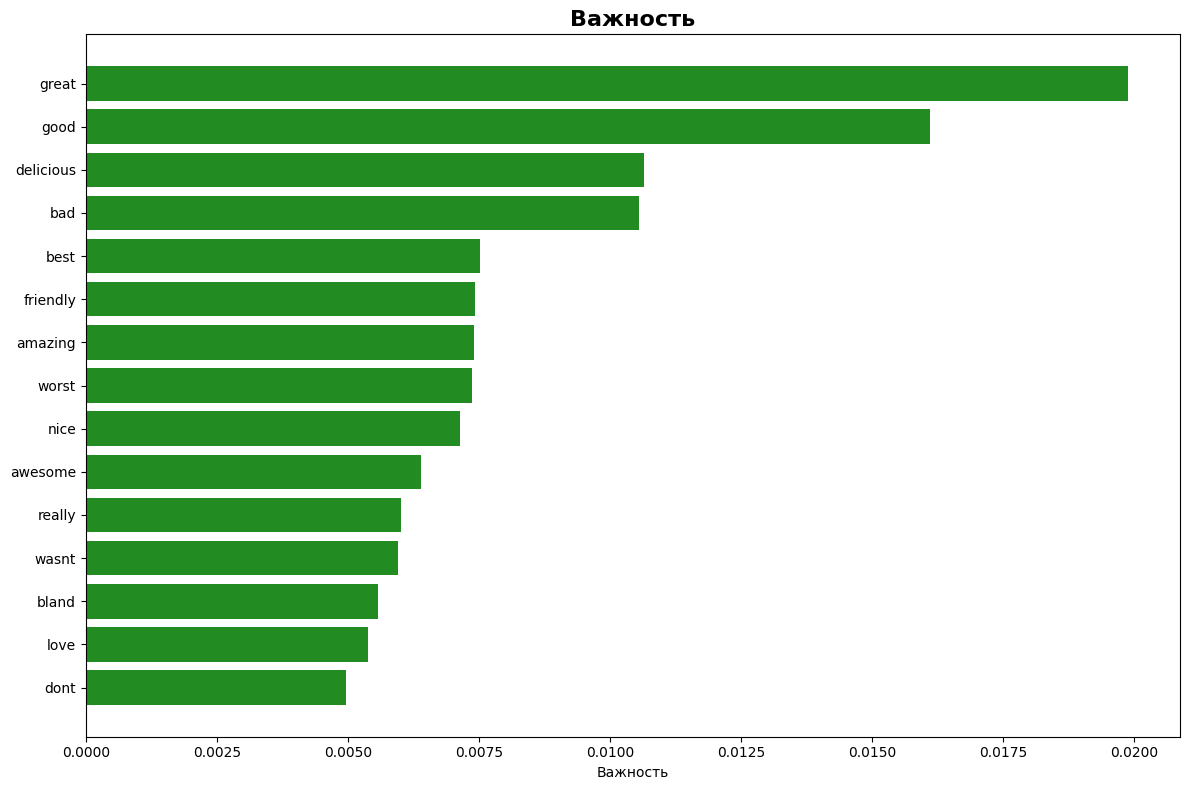

 1. great                → 0.0199
 2. good                 → 0.0161
 3. delicious            → 0.0107
 4. bad                  → 0.0105
 5. best                 → 0.0075
 6. friendly             → 0.0074
 7. amazing              → 0.0074
 8. worst                → 0.0074
 9. nice                 → 0.0071
10. awesome              → 0.0064
11. really               → 0.0060
12. wasnt                → 0.0060
13. bland                → 0.0056
14. love                 → 0.0054
15. dont                 → 0.0050


In [20]:
# улучшенный RandomForestClassifier с GridSearchCV

vectorizer_imp = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words='english'
)

X_clf_imp = vectorizer_imp.fit_transform(reviews['Review_clean'])
y_clf = reviews['Liked']

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X_clf_imp, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [None, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'oob_score': [True]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_c2, y_train_c2)

print(f"Лучшие параметры: {rf_grid.best_params_}")
print(f"Лучшая accuracy на CV: {rf_grid.best_score_:.4f}")

best_rf = rf_grid.best_estimator_
pred = best_rf.predict(X_test_c2)
proba = best_rf.predict_proba(X_test_c2)[:, 1]

acc = accuracy_score(y_test_c2, pred)
f1 = f1_score(y_test_c2, pred)
oob = best_rf.oob_score_

print(f"\nТЕСТОВЫЕ МЕТРИКИ:")
print(f"Accuracy:    {acc:.4f}")
print(f"F1-score:    {f1:.4f}")
print(f"ROC-AUC:     {roc_auc_score(y_test_c2, proba):.4f}")
print(f"OOB-оценка:  {oob:.4f}")

results.append({
    'Задача': 'Классификация',
    'Этап': 'Улучшенный + GridSearch',
    'Модель': 'RandomForest',
    'Accuracy': acc,
    'F1': f1
})

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]
feature_names = vectorizer_imp.get_feature_names_out()

plt.figure(figsize=(12, 8))
plt.title("Важность", fontsize=16, fontweight='bold')
plt.barh(range(len(indices)), importances[indices][::-1], color='forestgreen')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
plt.xlabel("Важность")
plt.tight_layout()
plt.show()

for i, idx in enumerate(indices, 1):
    print(f"{i:2d}. {feature_names[idx]:<20} → {importances[idx]:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие параметры: {'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Лучшее MAE на CV: 0.38
MAE:         51.03   ← было в бейзлайне: 68.29
RMSE:        84.64
OOB R²:      0.3924


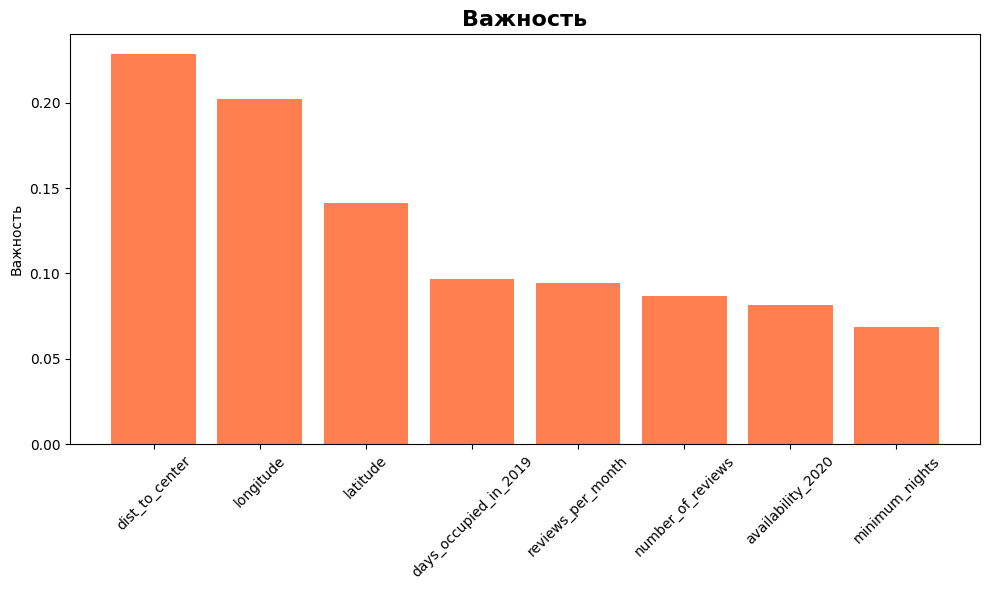

1. dist_to_center       → 0.2287
2. longitude            → 0.2021
3. latitude             → 0.1412
4. days_occupied_in_2019 → 0.0970
5. reviews_per_month    → 0.0944
6. number_of_reviews    → 0.0867
7. availability_2020    → 0.0814
8. minimum_nights       → 0.0686


In [22]:
# улучшенный RandomForestRegressor с GridSearchCV

df_reg = ny[(ny['price'] > 10) & (ny['price'] < 800)].copy()
df_reg['log_price'] = np.log1p(df_reg['price'])

times_square_lat = 40.7580
times_square_lon = -73.9855
df_reg['dist_to_center'] = np.sqrt(
    (df_reg['latitude'] - times_square_lat)**2 + 
    (df_reg['longitude'] - times_square_lon)**2
) * 111

features_reg = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'availability_2020', 'days_occupied_in_2019', 'dist_to_center']

X_reg_imp = df_reg[features_reg].fillna(0)
y_reg_imp = df_reg['log_price']

X_train_r2, X_test_r2, y_train_r2, y_test_r2 = train_test_split(
    X_reg_imp, y_reg_imp, test_size=0.2, random_state=42
)

rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        oob_score=True,
        bootstrap=True
    ))
])

param_grid = {
    'rf__n_estimators': [300, 500],
    'rf__max_depth': [None, 30],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2', 0.8]
}

grid_rf = GridSearchCV(
    rf_pipe, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_r2, y_train_r2)

print(f"Лучшие параметры: {grid_rf.best_params_}")
print(f"Лучшее MAE на CV: {-grid_rf.best_score_:.2f}")

best_rf_reg = grid_rf.best_estimator_
pred_log = best_rf_reg.predict(X_test_r2)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_test_r2)

mae_final = mean_absolute_error(true_price, pred_price)
rmse_final = np.sqrt(mean_squared_error(true_price, pred_price))
oob_r2 = best_rf_reg.named_steps['rf'].oob_score_

print(f"MAE:         {mae_final:.2f}   ← было в бейзлайне: {mae_base:.2f}")
print(f"RMSE:        {rmse_final:.2f}")
print(f"OOB R²:      {oob_r2:.4f}")

results.append({
    'Задача': 'Регрессия',
    'Этап': 'УЛУЧШЕННЫЙ + GridSearch',
    'Модель': 'RandomForest',
    'MAE': mae_final,
    'RMSE': rmse_final
})

importances = best_rf_reg.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Важность", fontsize=16, fontweight='bold')
plt.bar(range(len(importances)), importances[indices], color='coral')
plt.xticks(range(len(importances)), [features_reg[i] for i in indices], rotation=45)
plt.ylabel("Важность")
plt.tight_layout()
plt.show()

for i, idx in enumerate(indices):
    print(f"{i+1}. {features_reg[idx]:<20} → {importances[idx]:.4f}")

In [25]:
# моя реализация Random Forest

import random

class _BaseTreeRegressor:
    def __init__(self, max_depth=10, min_samples_split=5):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
    
    def _mse(self, y):
        return np.var(y) * len(y) if len(y) > 0 else 0
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feat, best_thr = None, None
        n_features = X.shape[1]
        features_to_check = random.sample(range(n_features), int(np.sqrt(n_features)) + 1)
        
        for feat in features_to_check:
            thresholds = np.unique(X[:, feat])
            for thr in thresholds:
                left = y[X[:, feat] <= thr]
                right = y[X[:, feat] > thr]
                if len(left) < 2 or len(right) < 2:
                    continue
                gain = self._mse(y) - (self._mse(left) + self._mse(right))
                if gain > best_gain:
                    best_gain, best_feat, best_thr = gain, feat, thr
        return best_feat, best_thr
    
    def _build(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)
        feat, thr = self._best_split(X, y)
        if feat is None:
            return np.mean(y)
        left_mask = X[:, feat] <= thr
        left = self._build(X[left_mask], y[left_mask], depth + 1)
        right = self._build(X[~left_mask], y[~left_mask], depth + 1)
        return (feat, thr, left, right)
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.tree = self._build(X, y)
    
    def _predict_one(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        feat, thr, left, right = tree
        return self._predict_one(x, left) if x[feat] <= thr else self._predict_one(x, right)
    
    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_one(x, self.tree) for x in X])

class MyRandomForestRegressor:
    def __init__(self, n_trees=100, max_depth=12, min_samples_split=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.trees = []
        for i in range(self.n_trees):
            idx = np.random.choice(len(X), len(X), replace=True)
            tree = _BaseTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)
    
    def predict(self, X):
        X = np.array(X)
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

class MyRandomForestClassifier:
    def __init__(self, n_trees=100, max_depth=12, min_samples_split=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.trees = []
        for i in range(self.n_trees):
            idx = np.random.choice(len(X), len(X), replace=True)
            tree = _BaseTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)
    
    def predict_proba(self, X):
        X = np.array(X)
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return predictions 
    
    def predict(self, X):
        probas = self.predict_proba(X)
        avg_probas = np.mean(probas, axis=0)
        return np.round(avg_probas).astype(int)

In [26]:

# Классификация отзывов — Random Forest 

X_train_c2_arr = X_train_c2.toarray() if hasattr(X_train_c2, 'toarray') else np.array(X_train_c2)
X_test_c2_arr  = X_test_c2.toarray()  if hasattr(X_test_c2,  'toarray') else np.array(X_test_c2)
y_train_np = np.array(y_train_c2)
y_test_np  = np.array(y_test_c2)

my_rf_clf = MyRandomForestClassifier(
    n_trees=100,
    max_depth=15,
    min_samples_split=5
)

my_rf_clf.fit(X_train_c2_arr, y_train_np)

pred = my_rf_clf.predict(X_test_c2_arr)

acc = accuracy_score(y_test_np, pred)
f1  = f1_score(y_test_np, pred)

print(f"\nМОЙ RANDOM FOREST → Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

results.append({
    'Задача': 'Классификация',
    'Этап': 'СВОЯ РЕАЛИЗАЦИЯ RANDOM FOREST',
    'Модель': 'MyRandomForest',
    'Accuracy': acc,
    'F1': f1
})


МОЙ RANDOM FOREST → Accuracy: 0.7700 | F1-score: 0.7553


In [27]:
# финальная таблица результатов

final_df = pd.DataFrame(results)

clf_df = final_df[final_df['Задача'] == 'Классификация'][['Этап', 'Модель', 'Accuracy', 'F1']].round(4)
display(clf_df.style
        .background_gradient(cmap='Greens', subset=['Accuracy', 'F1'])
        .set_table_styles([{
            'selector': 'caption',
            'props': [('font-size', '18pt'), ('font-weight', 'bold'), ('color', 'darkgreen'), ('text-align', 'center')]
        }]))

reg_df = final_df[final_df['Задача'] == 'Регрессия'][['Этап', 'Модель', 'MAE', 'RMSE']].round(2)
reg_df = reg_df.fillna('-')

display(reg_df.style
        .background_gradient(cmap='Oranges', subset=['MAE', 'RMSE'])
        .set_table_styles([{
            'selector': 'caption',
            'props': [('font-size', '18pt'), ('font-weight', 'bold'), ('color', 'darkred'), ('text-align', 'center')]
        }]))

display(final_df.round(4).style
        .background_gradient(cmap='plasma', subset=['Accuracy', 'F1', 'MAE', 'RMSE'])
        .set_table_styles([{
            'selector': 'caption',
            'props': [('font-size', '20pt'), ('font-weight', 'bold'), ('color', 'purple'), ('text-align', 'center')]
        }]))

,Этап,Модель,Accuracy,F1
0,Бейзлайн,RandomForest,0.770000,0.762900
3,Улучшенный + GridSearch,RandomForest,0.770000,0.770000
4,Улучшенный + GridSearch,RandomForest,0.770000,0.770000
5,Улучшенный + GridSearch,RandomForest,0.770000,0.770000
7,СВОЯ РЕАЛИЗАЦИЯ RANDOM FOREST,MyRandomForest,0.770000,0.755300


,Этап,Модель,MAE,RMSE
1,Бейзлайн,RandomForest,68.290000,168.590000
2,Бейзлайн,RandomForest,68.290000,168.590000
6,УЛУЧШЕННЫЙ + GridSearch,RandomForest,51.030000,84.640000


,Задача,Этап,Модель,Accuracy,F1,MAE,RMSE
0,Классификация,Бейзлайн,RandomForest,0.770000,0.762900,nan,nan
1,Регрессия,Бейзлайн,RandomForest,nan,nan,68.285800,168.589000
2,Регрессия,Бейзлайн,RandomForest,nan,nan,68.285800,168.589000
3,Классификация,Улучшенный + GridSearch,RandomForest,0.770000,0.770000,nan,nan
4,Классификация,Улучшенный + GridSearch,RandomForest,0.770000,0.770000,nan,nan
5,Классификация,Улучшенный + GridSearch,RandomForest,0.770000,0.770000,nan,nan
6,Регрессия,УЛУЧШЕННЫЙ + GridSearch,RandomForest,nan,nan,51.025800,84.639900
7,Классификация,СВОЯ РЕАЛИЗАЦИЯ RANDOM FOREST,MyRandomForest,0.770000,0.755300,nan,nan
